# Machine Learning for San Diego

In [1]:
# Standard Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
import glob

import warnings
warnings.filterwarnings('ignore')

# Word Cloud
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Ryan
[nltk_data]     Luu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#path = 'C:/Users/Ryan/Documents/Github/ML-SD-Project/'
path = 'C:/Users/Ryan Luu/Documents/Github/ML-SD-Project/'

all_files = glob.glob(path + "data/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

raw = pd.concat(li, axis=0, ignore_index=True)

In [3]:
raw.tail()

,service_request_id,service_request_parent_id,sap_notification_number,date_requested,case_age_days,service_name,case_record_type,date_updated,status,lat,lng,council_district,comm_plan_code,comm_plan_name,park_name,case_origin,referred,public_description
681422,2837762,NaN,NaN,2019-12-31T23:28:00,1.0,Citizen Contact,Parking,2020-01-02T00:00:00,Closed,32.707425,-117.093231,4.0,11.0,Encanto Neighborhoods,NaN,Mobile,NaN,Loud fireworks and loud music coming fromEl Re...
681423,2837763,NaN,NaN,2019-12-31T23:32:00,6.0,72 Hour Violation,Parking,2020-01-07T00:00:00,Closed,32.767174,-117.122808,3.0,59.0,Mid-City:Normal Heights,NaN,Mobile,NaN,Car has been parked for at least two weeks in ...
681424,2837764,NaN,NaN,2019-12-31T23:35:00,1.0,Citizen Contact,Parking,2020-01-02T00:00:00,Closed,32.751146,-117.250123,2.0,23.0,Ocean Beach,NaN,Mobile,NaN,Apartment residents are throwing fireworks at ...
681425,2837765,NaN,NaN,2019-12-31T23:45:00,2.0,Illegal Dumping,ESD Complaint/Report,2020-01-03T00:00:00,Closed,32.709147,-117.059223,4.0,11.0,Encanto Neighborhoods,NaN,Mobile,NaN,NaN
681426,2837766,NaN,NaN,2019-12-31T23:47:00,16.0,Graffiti Removal,TSW,NaN,In Process,32.708987,-117.060182,4.0,11.0,Encanto Neighborhoods,NaN,Mobile,NaN,NaN


In [4]:
print("There are " + str(raw.shape[0]) + " observations and " + str(raw.shape[1]) + " variables.")

There are 681427 observations and 18 variables.


# Data Cleaning and Manipulation

In [5]:
# Remove unnecessary columns
raw = raw.drop(["service_request_id", "service_request_parent_id", "sap_notification_number",'referred'], axis=1)

In [6]:
df = raw
# Convert back into datetime64
df['date_requested'] = pd.to_datetime(df['date_requested'])

# Extract date, month, time
df['date'] = df.date_requested.dt.date 
df['month'] = df.date_requested.dt.month
df['time'] = df.date_requested.dt.time

# Better Season
def gs(x):
    if (x == 12) or (x < 3):
        return 'Winter'
    elif (x >= 3) and (x < 6):
        return 'Spring'
    elif (x >= 6) and (x < 9):
        return 'Summer'
    elif (x >= 9) and (x < 12):
        return 'Fall'
    else: 
        return 'Error'

df['season'] = df.month.apply(lambda x: gs(x))

# Time of the Day Variable
def gt(x):
    if (x >= 0) and (x <= 5):
        return 'Past Midnight'
    elif (x > 5) and (x <= 11):
        return 'Morning'
    elif (x > 11) and (x <= 17):
        return 'Afternoon'
    elif (x > 17) and (x <= 23):
        return 'Evening'

df['tod'] = df.date_requested.dt.hour.apply(lambda x: gt(x))

# Make new DOW (day of week) variable
df['dow'] = df.date.apply(lambda x: pd.Timestamp(str(x)).weekday_name)

# Lowercase public description
df.public_description = df.public_description.apply(lambda x: str(x).lower())

# Month 
df.month[df.month == 1] = 'Jan'
df.month[df.month == 2] = 'Feb'
df.month[df.month == 3] = 'Mar'
df.month[df.month == 4] = 'Apr'
df.month[df.month == 5] = 'May'
df.month[df.month == 6] = 'Jun'
df.month[df.month == 7] = 'Jul'
df.month[df.month == 8] = 'Aug'
df.month[df.month == 9] = 'Jan'
df.month[df.month == 10] = 'Oct'
df.month[df.month == 11] = 'Nov'
df.month[df.month == 12] = 'Dec'

#Cleaning and replacing nan in council district with 0
df['council_district'] = df.council_district.fillna(0)
df['council_district'] = df.council_district.astype(np.int64)
df['council_district'] = df.council_district.apply(lambda x: 'district ' + str(x))

# Remove 'Test' observations from public description
df = df[~df.public_description.str.contains('test')]

# Setting Conditions for Dataframe
df['lat'] = df['lat'].astype(float)
df['lng'] = df['lng'].astype(float)
df2 = df[(df['lat'] > 32.5444) &
        (df['lat'] < 33.4274) &
        (df['lng'] < -117.0301) &
        (df['lng'] > -117.6126)]
        #(df['status'] == 'Closed')]

df2.tail()

,date_requested,case_age_days,service_name,case_record_type,date_updated,status,lat,lng,council_district,comm_plan_code,comm_plan_name,park_name,case_origin,public_description,date,month,time,season,tod,dow
681422,2019-12-31 23:28:00,1.0,Citizen Contact,Parking,2020-01-02T00:00:00,Closed,32.707425,-117.093231,district 4,11.0,Encanto Neighborhoods,NaN,Mobile,loud fireworks and loud music coming fromel re...,2019-12-31,Dec,23:28:00,Winter,Evening,Tuesday
681423,2019-12-31 23:32:00,6.0,72 Hour Violation,Parking,2020-01-07T00:00:00,Closed,32.767174,-117.122808,district 3,59.0,Mid-City:Normal Heights,NaN,Mobile,car has been parked for at least two weeks in ...,2019-12-31,Dec,23:32:00,Winter,Evening,Tuesday
681424,2019-12-31 23:35:00,1.0,Citizen Contact,Parking,2020-01-02T00:00:00,Closed,32.751146,-117.250123,district 2,23.0,Ocean Beach,NaN,Mobile,apartment residents are throwing fireworks at ...,2019-12-31,Dec,23:35:00,Winter,Evening,Tuesday
681425,2019-12-31 23:45:00,2.0,Illegal Dumping,ESD Complaint/Report,2020-01-03T00:00:00,Closed,32.709147,-117.059223,district 4,11.0,Encanto Neighborhoods,NaN,Mobile,nan,2019-12-31,Dec,23:45:00,Winter,Evening,Tuesday
681426,2019-12-31 23:47:00,16.0,Graffiti Removal,TSW,NaN,In Process,32.708987,-117.060182,district 4,11.0,Encanto Neighborhoods,NaN,Mobile,nan,2019-12-31,Dec,23:47:00,Winter,Evening,Tuesday


In [7]:
print("There are " + str(df2.shape[0]) + " observations and " + str(df2.shape[1]) + " variables.")

There are 654798 observations and 20 variables.


# Exploratory Data Analysis

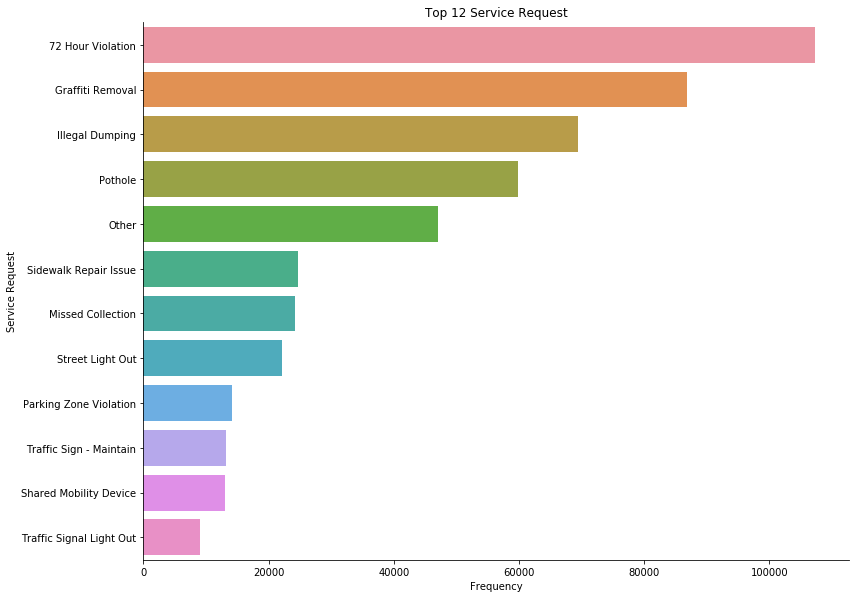

In [8]:
a= sns.catplot(y = 'service_name',
           kind = 'count',
           height = 8,
           aspect = 1.5,
           order = df2.service_name.value_counts().head(12).index,
           data = df2)
plt.title("Top 12 Service Request")
a.set(xlabel='Frequency', ylabel='Service Request')

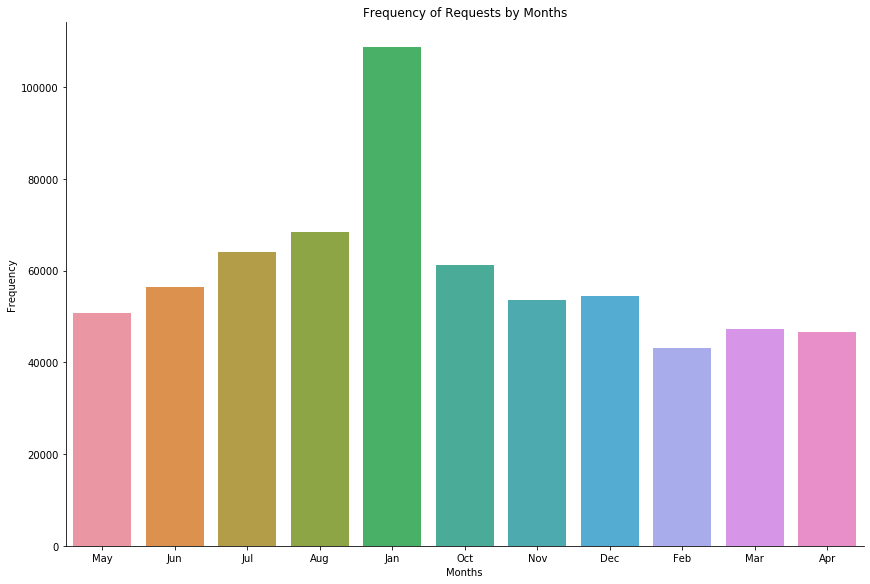

In [9]:
a = sns.catplot(x='month',
            kind='count',
            height=8, 
            aspect=1.5,
            data=df2)

plt.title("Frequency of Requests by Months")
a.set(xlabel="Months",ylabel="Frequency")
plt.show()

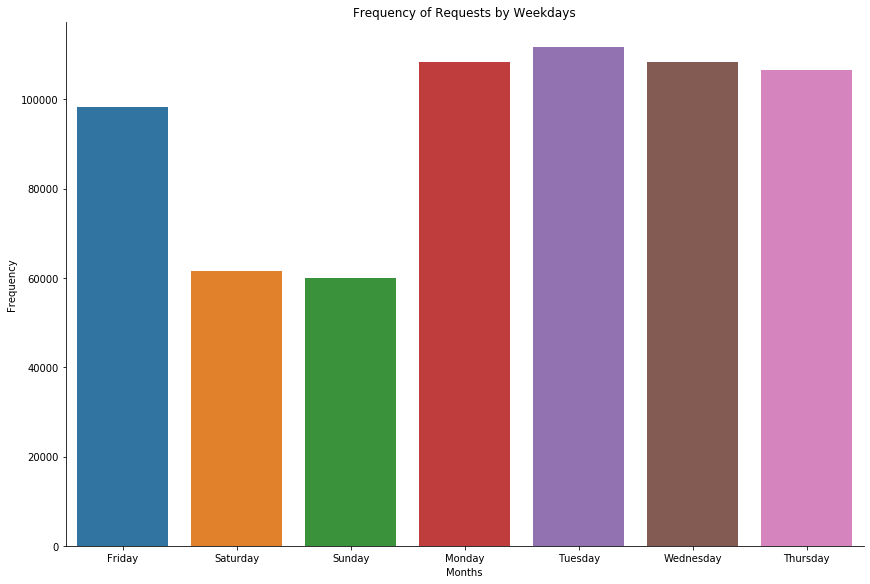

In [10]:
a = sns.catplot(x='dow',
            kind='count',
            height=8, 
            aspect=1.5,
            data=df2)

plt.title("Frequency of Requests by Weekdays")
a.set(xlabel="Months",ylabel="Frequency")
plt.show()

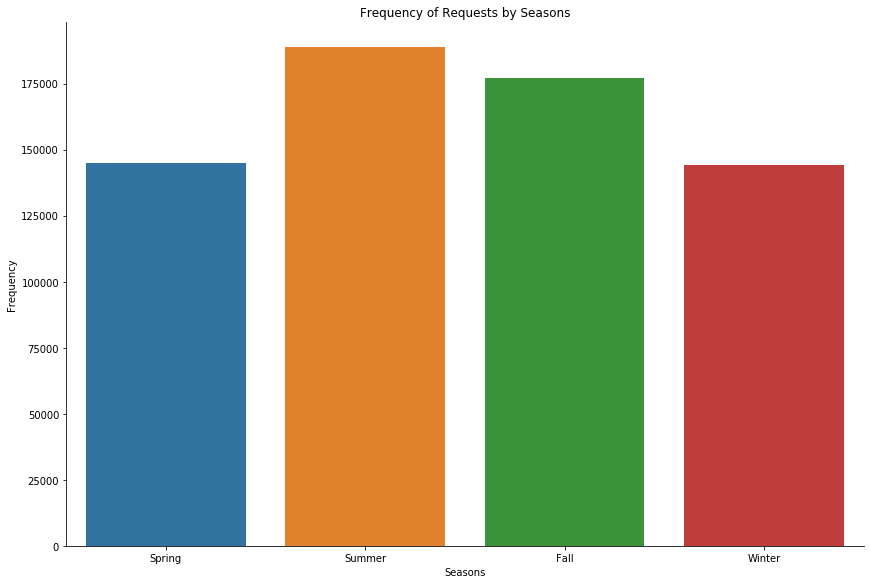

In [11]:
a = sns.catplot(x='season',
            kind='count',
            height=8, 
            aspect=1.5,
            data=df2)

plt.title("Frequency of Requests by Seasons")
a.set(xlabel="Seasons",ylabel="Frequency")
plt.show()

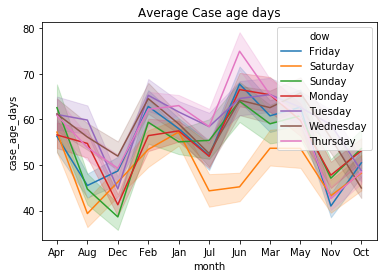

In [12]:
c = sns.lineplot(x="month",
                y="case_age_days",
                hue='dow',
                data=df2
                ).set_title('Average Case age days')
plt.show()

# WordCloud

In [13]:
# Clean nan from public description
desc = ((df2[~df2.public_description.str.contains('nan')])['public_description'])
string = desc.to_string()

In [14]:
s = stopwords.words('english')
print(s)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

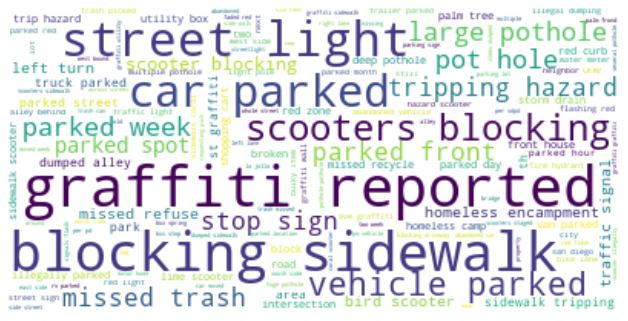

In [15]:
wordcloud = WordCloud(stopwords = s, background_color='white').generate(string)

# Plot
plt.figure(figsize=(11,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Preparing New Dataframe

In [16]:
df2.tail(10)

,date_requested,case_age_days,service_name,case_record_type,date_updated,status,lat,lng,council_district,comm_plan_code,comm_plan_name,park_name,case_origin,public_description,date,month,time,season,tod,dow
681417,2019-12-31 23:01:00,7.0,72 Hour Violation,Parking,2020-01-07T00:00:00,Closed,32.701780,-117.115930,district 9,37.0,Southeastern San Diego,NaN,Web,flat bed parker over 2 weeks. unknown owner.,2019-12-31,Dec,23:01:00,Winter,Evening,Tuesday
681418,2019-12-31 23:04:00,NaN,Other,TSW,2020-01-01T00:00:00,Referred,32.826648,-117.079842,district 7,47.0,Tierrasanta,NaN,Mobile,dumping of scooters in the brush,2019-12-31,Dec,23:04:00,Winter,Evening,Tuesday
681419,2019-12-31 23:07:00,16.0,Street Light Out,TSW,NaN,In Process,32.826119,-117.077974,district 7,47.0,Tierrasanta,NaN,Mobile,street light has been out for a month. locatio...,2019-12-31,Dec,23:07:00,Winter,Evening,Tuesday
681420,2019-12-31 23:08:00,1.0,NaN,Parking,2020-01-02T00:00:00,Closed,32.799915,-117.244770,district 2,27.0,Pacific Beach,NaN,Mobile,fireworks in the joint use field on or around ..,2019-12-31,Dec,23:08:00,Winter,Evening,Tuesday
681421,2019-12-31 23:17:00,NaN,Other,TSW,2020-01-01T00:00:00,Referred,32.722895,-117.156008,district 3,4.0,Downtown,NaN,Mobile,ive caught this car illegally parking almost e...,2019-12-31,Dec,23:17:00,Winter,Evening,Tuesday
681422,2019-12-31 23:28:00,1.0,Citizen Contact,Parking,2020-01-02T00:00:00,Closed,32.707425,-117.093231,district 4,11.0,Encanto Neighborhoods,NaN,Mobile,loud fireworks and loud music coming fromel re...,2019-12-31,Dec,23:28:00,Winter,Evening,Tuesday
681423,2019-12-31 23:32:00,6.0,72 Hour Violation,Parking,2020-01-07T00:00:00,Closed,32.767174,-117.122808,district 3,59.0,Mid-City:Normal Heights,NaN,Mobile,car has been parked for at least two weeks in ...,2019-12-31,Dec,23:32:00,Winter,Evening,Tuesday
681424,2019-12-31 23:35:00,1.0,Citizen Contact,Parking,2020-01-02T00:00:00,Closed,32.751146,-117.250123,district 2,23.0,Ocean Beach,NaN,Mobile,apartment residents are throwing fireworks at ...,2019-12-31,Dec,23:35:00,Winter,Evening,Tuesday
681425,2019-12-31 23:45:00,2.0,Illegal Dumping,ESD Complaint/Report,2020-01-03T00:00:00,Closed,32.709147,-117.059223,district 4,11.0,Encanto Neighborhoods,NaN,Mobile,nan,2019-12-31,Dec,23:45:00,Winter,Evening,Tuesday
681426,2019-12-31 23:47:00,16.0,Graffiti Removal,TSW,NaN,In Process,32.708987,-117.060182,district 4,11.0,Encanto Neighborhoods,NaN,Mobile,nan,2019-12-31,Dec,23:47:00,Winter,Evening,Tuesday


In [17]:
# Normalize function
def norm(x):
    r = (x-min(x))/(max(x)-min(x))
    return(r)

In [18]:
# Convert into categorical
'''
df2['season'] = df['season'].astype('category')
df2['dow'] = df['dow'].astype('category')
df2['case_record_type'] = df['case_record_type'].astype('category')
df2['council_district'] = df['council_district'].astype('category')
df2['month'] = df['month'].astype('category')
'''

df2.season = pd.Categorical(df2.season)
df2.dow = pd.Categorical(df2.dow)
df2.case_record_type = pd.Categorical(df2.case_record_type)
df2.council_district = pd.Categorical(df2.council_district)
df2.month = pd.Categorical(df2.month)
df2.comm_plan_name = pd.Categorical(df2.comm_plan_name)
df2.tod = pd.Categorical(df2.tod)

In [19]:
df3 = pd.get_dummies(df2, columns=['dow'], prefix = [None])
df3 = pd.get_dummies(df3, columns=['month'], prefix = [None])
df3 = pd.get_dummies(df3, columns=['season'], prefix = [None])
df3 = pd.get_dummies(df3, columns=['council_district'], prefix = [None])
df3 = pd.get_dummies(df3, columns = ['comm_plan_name'], prefix = [None])
df3 = pd.get_dummies(df3, columns = ['tod'], prefix = [None])

df3['normLat'] = norm(df3.lat)
df3['normLng'] = norm(df3.lng)

df3.head()

,date_requested,case_age_days,service_name,case_record_type,date_updated,status,lat,lng,comm_plan_code,park_name,...,Torrey Pines,University,Uptown,Via De La Valle,Afternoon,Evening,Morning,Past Midnight,normLat,normLng
1,2016-05-20 05:04:00,NaN,Parking Meter,TSW,NaN,Referred,32.726553,-117.125296,8.0,NaN,...,0,0,0,0,0,0,0,1,0.235527,0.740319
2,2016-05-20 05:05:00,NaN,72 Hour Violation,Parking,NaN,Referred,32.726523,-117.125532,8.0,NaN,...,0,0,0,0,0,0,0,1,0.235488,0.739677
3,2016-05-20 05:05:00,NaN,Dead Animal,TSW,NaN,Referred,32.726365,-117.125478,8.0,NaN,...,0,0,0,0,0,0,0,1,0.235284,0.739824
5,2016-05-20 05:06:00,NaN,Illegal Dumping,ESD Complaint/Report,NaN,Referred,32.727625,-117.124705,28.0,NaN,...,0,0,0,0,0,0,0,1,0.236913,0.741932
6,2016-05-20 05:07:00,NaN,Illegal Dumping,ESD Complaint/Report,NaN,Referred,32.726341,-117.125474,8.0,NaN,...,0,0,0,0,0,0,0,1,0.235253,0.739833


In [20]:
# Drop column not needed for training
df3 = df3.drop(["date_requested", "case_age_days", "service_name",'date_updated', 'status',
                'lat','lng','comm_plan_code','park_name',
               'public_description','date','time','case_origin'], axis=1)

In [21]:
df3.head()

,case_record_type,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Apr,Aug,...,Torrey Pines,University,Uptown,Via De La Valle,Afternoon,Evening,Morning,Past Midnight,normLat,normLng
1,TSW,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.235527,0.740319
2,Parking,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.235488,0.739677
3,TSW,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.235284,0.739824
5,ESD Complaint/Report,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.236913,0.741932
6,ESD Complaint/Report,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.235253,0.739833


In [22]:
# View unique classes
df3.case_record_type.unique()

[TSW, Parking, ESD Complaint/Report, Traffic Engineering, DSD, TSW ROW, Storm Water Code Enforcement]
Categories (7, object): [TSW, Parking, ESD Complaint/Report, Traffic Engineering, DSD, TSW ROW, Storm Water Code Enforcement]

In [23]:
# Convert case_record_type into integer category
def dep(x):
    if x == 'TSW':
        return 0
    if x == 'Parking':
        return 1
    if x == 'ESD Complaint/Report':
        return 2
    if x == 'Traffic Engineering':
        return 3
    if x == 'DSD':
        return 4
    if x == 'TSW ROW':
        return 5
    if x == 'Storm Water Code Enforcement':
        return 6    
        
df3.case_record_type = df3.case_record_type.apply(lambda x: dep(x))

In [24]:
df3.tail()

,case_record_type,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Apr,Aug,...,Torrey Pines,University,Uptown,Via De La Valle,Afternoon,Evening,Morning,Past Midnight,normLat,normLng
681422,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.210793,0.827789
681423,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.288050,0.747107
681424,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.267326,0.399810
681425,2,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.213020,0.920558
681426,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.212813,0.917942


# Machine Learning Time!

#### Packages

In [59]:
# ML Packages
import tensorflow as tf
from tensorflow import keras

import scipy
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

#### Test and Train Split 

Hold-out method: Create train and test sets. Train the model with the train set and test on test set. Because of imbalanced classifers, I will be using scikit-learn's stratified train/test split to ensure that the train and test sets have approximately the same percentage of samples of each target class as the complete set.

In [81]:
# Change df3 into np.array & convert to float
np.random.seed(1234)
df3_nparray = df3.values

df3x = (df3_nparray[:,1:]).astype('float32')
df3y = (df3_nparray[:,[0]]).astype('float32')

In [82]:
# Stratified splitting
trainx, testx, trainy, testy = train_test_split(df3x, df3y,
                                                stratify=df3y,
                                                test_size=0.3)

#### Functions

In [61]:
# Accuracy Report
def cm_report(x,y):
    print('Accuracy Score: ', accuracy_score(x,y))
    print()
    print('Report')
    print(classification_report(x,y))

labels = ['TSW 0', 'Parking 1', 'ESD 2', 'Traf Eng 3',
          'DSD 4', 'TSW ROW 5', 'SWC Enf 6']

# Prediction Report    
def pred_report(x):
    print('Prediction Report')
    print('')
    prediction = x.predict_proba(testx)
    predictiondf = pd.DataFrame(data=prediction)
    predictiondf.rename(columns={i:j for i,j in zip(predictiondf.columns,labels)}, inplace = True)
    predictiondf['Class_Prediction'] = [labels[np.argmax(i)] for i in prediction]
    predictiondf['Pred'] = [int(labels[np.argmax(i)][-1:]) for i in prediction]
    predictiondf['Prob'] = [np.max(i) for i in prediction]
    predictiondf['Actual'] = testy.astype(int)
    predictiondf['Score'] = np.where(predictiondf.Actual == predictiondf.Pred, True, False)
    print(predictiondf.head(25))
    print('')
    
    predict = predictiondf.Pred.values
    actual = predictiondf.Actual.values
    cm_report(actual,predict)

# Neural Network

In [83]:
nn_model1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(95, )),
    keras.layers.Dense(128, activation=tf.nn.relu), #Rectified linear unit, common activation function
    #keras.layers.Dense(1, activation=tf.nn.relu),
    keras.layers.Dense(7, activation=tf.nn.softmax) # 7 classes in predicting service request type
])

nn_model1.compile(optimizer='adam',
             loss = 'sparse_categorical_crossentropy', # multiclass prediction
             metrics=['accuracy'])

In [84]:
nn_model1.fit(trainx, trainy, epochs=10)

Train on 458358 samples
Epoch 1/10
458358/458358 [==============================] - 16s 36us/sample - loss: 1.0560 - accuracy: 0.5635
Epoch 2/10
458358/458358 [==============================] - 16s 35us/sample - loss: 1.0430 - accuracy: 0.5668
Epoch 3/10
458358/458358 [==============================] - 16s 35us/sample - loss: 1.0395 - accuracy: 0.5682
Epoch 4/10
458358/458358 [==============================] - 16s 35us/sample - loss: 1.0369 - accuracy: 0.5690
Epoch 5/10
458358/458358 [==============================] - 16s 35us/sample - loss: 1.0350 - accuracy: 0.5698 - loss:
Epoch 6/10
458358/458358 [==============================] - 16s 35us/sample - loss: 1.0336 - accuracy: 0.5701
Epoch 7/10
458358/458358 [==============================] - 16s 35us/sample - loss: 1.0327 - accuracy: 0.5699
Epoch 8/10
458358/458358 [==============================] - 16s 35us/sample - loss: 1.0317 - accuracy: 0.5706
Epoch 9/10
458358/458358 [==============================] - 15s 33us/sample - loss: 1.03

In [31]:
train_loss, train_acc = nn_model1.evaluate(trainx, trainy)

print('Train accuracy:', train_acc)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train accuracy: 0.5736695


In [32]:
test_loss, test_acc = nn_model1.evaluate(testx, testy)

print('Test accuracy:', test_acc)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Test accuracy: 0.56987375


In [45]:
pred_report(nn_model1)

Prediction Report

       TSW 0  Parking 1     ESD 2  Traf Eng 3     DSD 4  TSW ROW 5  SWC Enf 6  \
0   0.667968   0.173253  0.131748    0.013766  0.002037   0.003831   0.007397   
1   0.581107   0.146392  0.259602    0.006334  0.001516   0.002674   0.002374   
2   0.464006   0.218140  0.289573    0.021755  0.002227   0.001911   0.002388   
3   0.591873   0.153144  0.234581    0.009770  0.003177   0.002593   0.004861   
4   0.534532   0.151564  0.284359    0.011999  0.004552   0.005649   0.007345   
5   0.576115   0.161924  0.232231    0.017074  0.001645   0.006018   0.004993   
6   0.655629   0.197808  0.098615    0.031354  0.002860   0.001165   0.012570   
7   0.356458   0.178102  0.452086    0.005223  0.001653   0.002970   0.003508   
8   0.720194   0.174341  0.073731    0.018844  0.004327   0.001920   0.006643   
9   0.522299   0.142088  0.318829    0.006091  0.002509   0.004203   0.003980   
10  0.787536   0.145361  0.051190    0.009523  0.001944   0.000478   0.003970   
11  0.266

# Synthetic Minority Oversampling Technique

Looking at the accuracy report above, we can see that the model has high precision for some classes, but not for others. Down below is a graph that illustrates the Case Record Type class distribution. To combat this, I will use SMOTE to oversample the minority class. In doing so, I hope to better train the model in predicting minority classes. 

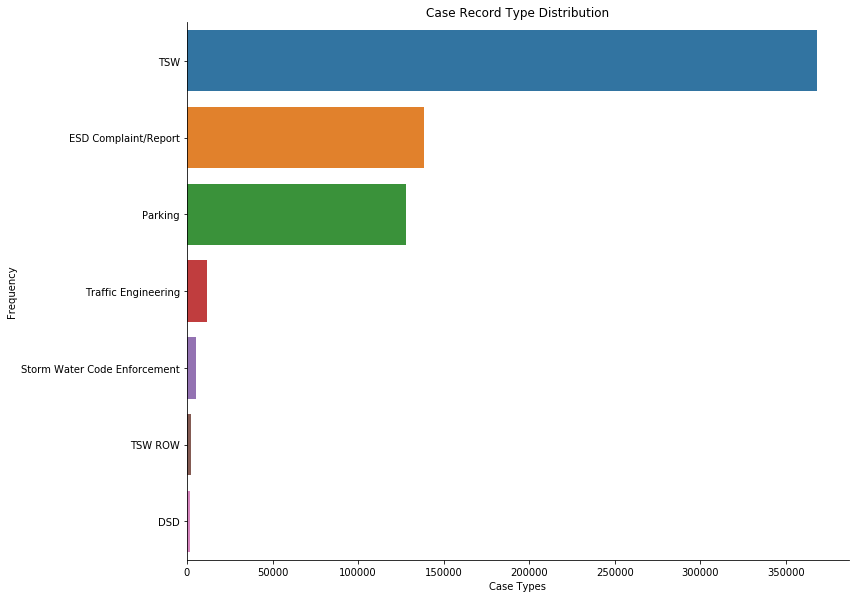

In [36]:
a = sns.catplot(y='case_record_type',
            kind='count',
            height=8, 
            aspect=1.5,
            order = df2.case_record_type.value_counts().index,
            data=df2)

plt.title("Case Record Type Distribution")
a.set(xlabel="Case Types",ylabel="Frequency")
plt.show()

In [37]:
# Oversample with SMOTE
sm = SMOTE(random_state=42)
trainx_res, trainy_res = sm.fit_resample(trainx, trainy)

In [38]:
print('New Class Distribution %s' % Counter(trainy_res)) 

New Class Distribution Counter({0.0: 257753, 2.0: 257753, 1.0: 257753, 3.0: 257753, 4.0: 257753, 6.0: 257753, 5.0: 257753})


# Training Neural Network using SMOTE train set

In [39]:
# fit() -> trains the model
nn_model2.fit(trainx_res, trainy_res, epochs=10)

Train on 1804271 samples
Epoch 1/10
1804271/1804271 [==============================] - 64s 36us/sample - loss: 1.3138 - accuracy: 0.4888
Epoch 2/10
1804271/1804271 [==============================] - 64s 36us/sample - loss: 1.1709 - accuracy: 0.5344
Epoch 3/10
1804271/1804271 [==============================] - 67s 37us/sample - loss: 1.1342 - accuracy: 0.5461 - loss: 1.1
Epoch 4/10
1804271/1804271 [==============================] - 67s 37us/sample - loss: 1.1146 - accuracy: 0.5521
Epoch 5/10
1804271/1804271 [==============================] - 65s 36us/sample - loss: 1.1024 - accuracy: 0.5557
Epoch 6/10
1804271/1804271 [==============================] - 68s 38us/sample - loss: 1.0936 - accuracy: 0.5585
Epoch 7/10
1804271/1804271 [==============================] - 68s 38us/sample - loss: 1.0871 - accuracy: 0.5601 - loss: 1.0
Epoch 8/10
1804271/1804271 [==============================] - 71s 39us/sample - loss: 1.0817 - accuracy: 0.5622
Epoch 9/10
1804271/1804271 [===========================

In [40]:
train_loss, train_acc = nn_model2.evaluate(trainx_res, trainy_res)

print('Train accuracy:', train_acc)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train accuracy: 0.5689694


In [41]:
test_loss, test_acc = nn_model2.evaluate(testx, testy)

print('Test accuracy:', test_acc)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Test accuracy: 0.3709275


In [42]:
pred_report(nn_model2)

Prediction Report

      TSW 0  Parking 1     ESD 2  Traf Eng 3     DSD 4  TSW ROW 5  SWC Enf 6  \
0  0.362028   0.171776  0.169897    0.164396  0.000028   0.062594   0.069282   
1  0.304688   0.186764  0.380349    0.047905  0.038745   0.039839   0.001711   
2  0.181396   0.296188  0.417772    0.102861  0.000001   0.001359   0.000423   
3  0.256246   0.195254  0.510545    0.023271  0.007025   0.000108   0.007552   
4  0.157258   0.113853  0.211794    0.025062  0.478034   0.000269   0.013730   
5  0.123071   0.125677  0.118618    0.139571  0.485784   0.006154   0.001126   
6  0.260334   0.287093  0.181483    0.265220  0.004262   0.000004   0.001604   
7  0.167155   0.269541  0.473769    0.050311  0.002041   0.007692   0.029490   
8  0.418192   0.396392  0.118224    0.066216  0.000014   0.000047   0.000915   
9  0.227355   0.155574  0.400798    0.042288  0.111171   0.001900   0.060915   

  Class_Prediction  Pred      Prob  Actual  Score  
0            TSW 0     0  0.362028       0   Tru

It appears the utilzing SMOTE to oversample the dataset did not necessarily increase the model's overall accuracy or class precision probably due to too much noise (it is important to note that it is one of the cons of using SMOTE). We synthesize class observations of DSD that has 900 observations to 180,000 instances.

# Let's Try Undersampling?

#### Near-Miss  

In [56]:
nm1 = NearMiss(version=1)
nm_x, nm_y = nm1.fit_resample(trainx,trainy)

In [57]:
print(sorted(Counter(nm_y).items()))

[(0.0, 1197), (1.0, 1197), (2.0, 1197), (3.0, 1197), (4.0, 1197), (5.0, 1197), (6.0, 1197)]


In [58]:
nn_model3.fit(nm_x, nm_y, epochs=10)

Train on 8379 samples
Epoch 1/10
8379/8379 [==============================] - 0s 38us/sample - loss: 1.5033 - accuracy: 0.4487
Epoch 2/10
8379/8379 [==============================] - 0s 36us/sample - loss: 1.2644 - accuracy: 0.5196
Epoch 3/10
8379/8379 [==============================] - 0s 36us/sample - loss: 1.1959 - accuracy: 0.5383
Epoch 4/10
8379/8379 [==============================] - 0s 37us/sample - loss: 1.1568 - accuracy: 0.5516
Epoch 5/10
8379/8379 [==============================] - 0s 36us/sample - loss: 1.1272 - accuracy: 0.5619
Epoch 6/10
8379/8379 [==============================] - 0s 36us/sample - loss: 1.1036 - accuracy: 0.5663
Epoch 7/10
8379/8379 [==============================] - 0s 37us/sample - loss: 1.0898 - accuracy: 0.5739
Epoch 8/10
8379/8379 [==============================] - 0s 37us/sample - loss: 1.0754 - accuracy: 0.5747
Epoch 9/10
8379/8379 [==============================] - 0s 37us/sample - loss: 1.0620 - accuracy: 0.5791
Epoch 10/10
8379/8379 [==========

In [59]:
test_loss, test_acc = nn_model3.evaluate(testx, testy)

print('Test accuracy:', test_acc)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Test accuracy: 0.05839442


In [60]:
pred_report(nn_model3)

Prediction Report

      TSW 0  Parking 1     ESD 2  Traf Eng 3     DSD 4  TSW ROW 5  SWC Enf 6  \
0  0.000391   0.000713  0.000282    0.020852  0.000029   0.951764   0.025970   
1  0.025272   0.114611  0.109839    0.134693  0.185052   0.428324   0.002209   
2  0.002433   0.025523  0.011985    0.769756  0.000816   0.166275   0.023212   
3  0.000549   0.004284  0.003410    0.318021  0.466642   0.021381   0.185712   
4  0.002076   0.041489  0.024092    0.070373  0.809771   0.004084   0.048115   
5  0.000284   0.000198  0.000147    0.002540  0.914264   0.082479   0.000087   
6  0.018339   0.124517  0.073905    0.644257  0.126810   0.000164   0.012008   
7  0.001910   0.019917  0.046662    0.202068  0.026327   0.256231   0.446885   
8  0.007389   0.021999  0.004143    0.865938  0.009384   0.006369   0.084777   
9  0.066667   0.194667  0.384931    0.204391  0.070296   0.009166   0.069882   

  Class_Prediction  Pred      Prob  Actual  Score  
0        TSW ROW 5     5  0.951764       0  Fals

Undersampling the majority classes to 900 instances hindered the model's accuracy due to huge information loss. Because of our results, we will move on and use the train dataset as is, without over or undersampling. 

# Multinomial Logistic Regression

In [61]:
clf = LogisticRegression(random_state=42,
                         multi_class='multinomial',
                         solver = 'newton-cg')

In [62]:
mlr_model = clf.fit(trainx, trainy)

In [63]:
pred_report(mlr_model)

Prediction Report

      TSW 0  Parking 1     ESD 2  Traf Eng 3     DSD 4  TSW ROW 5  SWC Enf 6  \
0  0.703770   0.135111  0.131643    0.021331  0.000906   0.002182   0.005057   
1  0.523942   0.142903  0.317741    0.008276  0.001639   0.002962   0.002536   
2  0.538682   0.233887  0.201436    0.016731  0.003183   0.002874   0.003206   
3  0.429449   0.169634  0.383724    0.008891  0.001761   0.002444   0.004098   
4  0.628340   0.175672  0.166769    0.014779  0.003908   0.005386   0.005146   
5  0.578089   0.171312  0.232599    0.010994  0.001795   0.002329   0.002881   
6  0.639555   0.210795  0.120734    0.020062  0.001842   0.002187   0.004825   
7  0.416581   0.195851  0.358544    0.011876  0.004313   0.004247   0.008589   
8  0.609139   0.257413  0.104720    0.017950  0.002755   0.002117   0.005906   
9  0.516832   0.143435  0.324587    0.007950  0.001558   0.003335   0.002302   

  Class_Prediction  Pred      Prob  Actual  Score  
0            TSW 0     0  0.703770       0   Tru

# Sandbox

##### Function

In [34]:
# Normalizes input's lat and lng 
def fix_lng(x):
    r = (x-(min(df2.lng)))/(max(df2.lng)-min(df2.lng))
    return(r)

def fix_lat(x):
    r = (x-(min(df2.lat)))/(max(df2.lat)-min(df2.lat))
    return(r)

In [35]:
# Create prediction table. Takes in the argument (model, input array)
def sam_report(x,y):
    print('Prediction Report')
    print('')
    prediction = x.predict_proba(y)
    predictiondf = pd.DataFrame(data=prediction)
    predictiondf.rename(columns={i:j for i,j in zip(predictiondf.columns,labels)}, inplace = True)
    predictiondf['Class_Prediction'] = [labels[np.argmax(i)] for i in prediction]
    predictiondf['Pred'] = [int(labels[np.argmax(i)][-1:]) for i in prediction]
    predictiondf['Prob'] = [np.max(i) for i in prediction]
    print(predictiondf.head(10))

##### Load a sample csv file with desired parameters 

In [36]:
# Insert the independent variables to make a prediction
inp = pd.read_csv("input/sample.csv", index_col=None, header=0)

In [37]:
inp.head()

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Apr,Aug,Dec,...,Torrey Pines,University,Uptown,Via De La Valle,Afternoon,Evening,Morning,Past Midnight,normLat,normLng
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,32.701780,-117.115930
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,32.813952,-117.064478
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,32.745823,-117.105142
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,32.799915,-117.244770
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,32.722895,-117.156008


In [38]:
inp['normLat'] = inp.normLat.apply(lambda x: fix_lat(x))
inp['normLng'] = inp.normLng.apply(lambda x: fix_lng(x))

In [39]:
inp.head()

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Apr,Aug,Dec,...,Torrey Pines,University,Uptown,Via De La Valle,Afternoon,Evening,Morning,Past Midnight,normLat,normLng
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0.203494,0.765869
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0.348535,0.906223
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.260443,0.795297
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.330385,0.414412
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.230797,0.656542


In [40]:
inp_nparray = inp.values

In [43]:
sam_report(nn_model1, inp_nparray)

Prediction Report

      TSW 0  Parking 1     ESD 2  Traf Eng 3     DSD 4  TSW ROW 5  SWC Enf 6  \
0  0.629633   0.213391  0.123056    0.005727  0.004906   0.003735   0.019553   
1  0.563256   0.113131  0.301494    0.010396  0.000404   0.000960   0.010359   
2  0.580270   0.094263  0.313545    0.005903  0.000935   0.001071   0.004013   
3  0.763360   0.115444  0.106830    0.008793  0.000666   0.000119   0.004787   
4  0.700924   0.158259  0.127053    0.002699  0.000896   0.002239   0.007930   
5  0.676220   0.150446  0.165602    0.004540  0.000670   0.001521   0.001001   
6  0.560704   0.179533  0.222775    0.016047  0.006859   0.009491   0.004590   
7  0.559211   0.264650  0.153393    0.017693  0.002236   0.001235   0.001581   
8  0.651340   0.171069  0.126316    0.011435  0.003499   0.004388   0.031953   
9  0.583248   0.158657  0.222728    0.005341  0.002982   0.001426   0.025619   

  Class_Prediction  Pred      Prob  
0            TSW 0     0  0.629633  
1            TSW 0     0  

# Feature Importance with Forest

In [37]:
from sklearn.ensemble import ExtraTreesClassifier

# DF Integer Encoding Instead of One Hot Encode

In [25]:
df2.head()

,date_requested,case_age_days,service_name,case_record_type,date_updated,status,lat,lng,council_district,comm_plan_code,comm_plan_name,park_name,case_origin,public_description,date,month,time,season,tod,dow
1,2016-05-20 05:04:00,NaN,Parking Meter,TSW,NaN,Referred,32.726553,-117.125296,district 3,8.0,Greater Golden Hill,NaN,Mobile,nan,2016-05-20,May,05:04:00,Spring,Past Midnight,Friday
2,2016-05-20 05:05:00,NaN,72 Hour Violation,Parking,NaN,Referred,32.726523,-117.125532,district 3,8.0,Greater Golden Hill,NaN,Mobile,nan,2016-05-20,May,05:05:00,Spring,Past Midnight,Friday
3,2016-05-20 05:05:00,NaN,Dead Animal,TSW,NaN,Referred,32.726365,-117.125478,district 3,8.0,Greater Golden Hill,NaN,Mobile,nan,2016-05-20,May,05:05:00,Spring,Past Midnight,Friday
5,2016-05-20 05:06:00,NaN,Illegal Dumping,ESD Complaint/Report,NaN,Referred,32.727625,-117.124705,district 3,28.0,North Park,NaN,Mobile,nan,2016-05-20,May,05:06:00,Spring,Past Midnight,Friday
6,2016-05-20 05:07:00,NaN,Illegal Dumping,ESD Complaint/Report,NaN,Referred,32.726341,-117.125474,district 3,8.0,Greater Golden Hill,NaN,Mobile,nan,2016-05-20,May,05:07:00,Spring,Past Midnight,Friday


In [26]:
df4 = df2.drop(["date_requested", "case_age_days", "service_name",'date_updated', 'status',
                'park_name', 'comm_plan_code',
               'public_description','date','time','case_origin'], axis=1)

In [27]:
df4.head()

,case_record_type,lat,lng,council_district,comm_plan_name,month,season,tod,dow
1,TSW,32.726553,-117.125296,district 3,Greater Golden Hill,May,Spring,Past Midnight,Friday
2,Parking,32.726523,-117.125532,district 3,Greater Golden Hill,May,Spring,Past Midnight,Friday
3,TSW,32.726365,-117.125478,district 3,Greater Golden Hill,May,Spring,Past Midnight,Friday
5,ESD Complaint/Report,32.727625,-117.124705,district 3,North Park,May,Spring,Past Midnight,Friday
6,ESD Complaint/Report,32.726341,-117.125474,district 3,Greater Golden Hill,May,Spring,Past Midnight,Friday


In [28]:
df4.council_district = df4.council_district.apply(lambda x: int(x[-1]))

In [29]:
df4.ftypes

case_record_type    category:dense
lat                  float64:dense
lng                  float64:dense
council_district    category:dense
comm_plan_name      category:dense
month               category:dense
season              category:dense
tod                 category:dense
dow                 category:dense
dtype: object

In [30]:
df4.head()

,case_record_type,lat,lng,council_district,comm_plan_name,month,season,tod,dow
1,TSW,32.726553,-117.125296,3,Greater Golden Hill,May,Spring,Past Midnight,Friday
2,Parking,32.726523,-117.125532,3,Greater Golden Hill,May,Spring,Past Midnight,Friday
3,TSW,32.726365,-117.125478,3,Greater Golden Hill,May,Spring,Past Midnight,Friday
5,ESD Complaint/Report,32.727625,-117.124705,3,North Park,May,Spring,Past Midnight,Friday
6,ESD Complaint/Report,32.726341,-117.125474,3,Greater Golden Hill,May,Spring,Past Midnight,Friday


In [31]:
# Integer encode
df4.council_district = df4.council_district.cat.codes
df4.comm_plan_name = df4.comm_plan_name.cat.codes
df4.month = df4.month.cat.codes
df4.season = df4.season.cat.codes
df4.tod = df4.tod.cat.codes
df4.dow = df4.dow.cat.codes
df4.case_record_type = df4.case_record_type.apply(lambda x: dep(x))

In [32]:
df4.head()

,case_record_type,lat,lng,council_district,comm_plan_name,month,season,tod,dow
1,0,32.726553,-117.125296,3,12,8,1,3,0
2,1,32.726523,-117.125532,3,12,8,1,3,0
3,0,32.726365,-117.125478,3,12,8,1,3,0
5,2,32.727625,-117.124705,3,30,8,1,3,0
6,2,32.726341,-117.125474,3,12,8,1,3,0


In [33]:
df4_nparray = df4.values

In [34]:
df4_nparray

array([[0, 32.72655311893732, -117.1252962550772, ..., 1, 3, 0],
       [1, 32.726523084704624, -117.1255315509597, ..., 1, 3, 0],
       [0, 32.72636528515659, -117.1254779581176, ..., 1, 3, 0],
       ...,
       [1, 32.75114637647673, -117.2501228270528, ..., 3, 1, 5],
       [2, 32.709146999999994, -117.059223, ..., 3, 1, 5],
       [0, 32.708987, -117.06018200000001, ..., 3, 1, 5]], dtype=object)

In [35]:
X = (df4_nparray[:,1:]).astype('float32')
y = (df4_nparray[:,[0]]).astype('float32')

In [38]:
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

In [39]:
forest.fit(X, y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=250,
                     n_jobs=None, oob_score=False, random_state=0, verbose=0,
                     warm_start=False)

In [40]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 0 (0.413352)
2. feature 1 (0.407621)
3. feature 7 (0.073608)
4. feature 4 (0.030197)
5. feature 6 (0.026477)
6. feature 3 (0.025960)
7. feature 5 (0.011654)
8. feature 2 (0.011130)


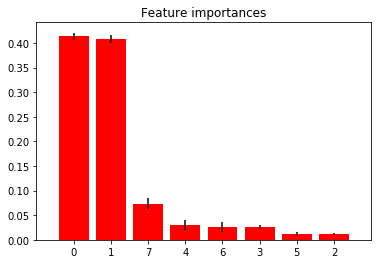

In [41]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# Limitations and Assumptions

The dataset does not account for duplicate requests. For example, if there was a street light out on a populated intersection, chances are many people may report the same problem. However, if there were a dead animal in small alley, not that many would report it. 

Just because the street light got more requests does not mean that it occurs more often than other service type requests.

We also have to keep in mind that people report what they want to report. For example, some people may not want to report Graffiti if they think it looks nice. If they report it, it would get taken down so they don't report it.
+